In [13]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.optimizers import Adam
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras import layers, models
from tensorflow import data as tf_data
keras.config.set_image_data_format("channels_first")

In [14]:
@keras.saving.register_keras_serializable()
class FireModule(layers.Layer):
    def __init__(self, squeeze_filters, expand1x1_filters, expand3x3_filters, name=None, **kwargs):
        super(FireModule, self).__init__(name=name, **kwargs)
        self.squeeze_filters = squeeze_filters
        self.expand1x1_filters = expand1x1_filters
        self.expand3x3_filters = expand3x3_filters
        # Define the layers for the Fire module
        self.squeeze = layers.Conv2D(self.squeeze_filters, (1, 1), activation='relu', data_format='channels_first')
        self.expand1x1 = layers.Conv2D(self.expand1x1_filters, (1, 1), activation='relu', data_format='channels_first')
        self.expand3x3 = layers.Conv2D(self.expand3x3_filters, (3, 3), padding='same', activation='relu', data_format='channels_first')

    def call(self, inputs):
        x = self.squeeze(inputs)
        x1 = self.expand1x1(x)
        x2 = self.expand3x3(x)
        #output = tf.concat([x1, x2], axis=1)  # Concatenate along the channel axis
        output = keras.ops.concatenate([x1, x2], axis=1) # Concatenate along the channel axis
        return output
    
    def get_config(self):
        config = super(FireModule, self).get_config()
        config.update(
            {

            "squeeze_filters": self.squeeze_filters,
            "expand1x1_filters": self.expand1x1_filters,
            "expand3x3_filters":self.expand3x3_filters
            }
        )
        return config

    @classmethod
    def from_config(cls, config):
        config['squeeze_filters'] = keras.saving.deserialize_keras_object(config['squeeze_filters'])
        config['expand1x1_filters'] = keras.saving.deserialize_keras_object(config['expand1x1_filters'])
        config['expand3x3_filters'] = keras.saving.deserialize_keras_object(config['expand3x3_filters'])
        return cls(**config)

In [15]:
# Load keras model
model = keras.models.load_model('minisqueezenet_96.keras',
    custom_objects={"FireModule": FireModule})

/home/pico/miniconda3/envs/torch/lib/python3.12/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'fire_module', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/pico/miniconda3/envs/torch/lib/python3.12/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'fire_module_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
This image is 96.25% human and 3.75% not human.
[[0.03748978]]


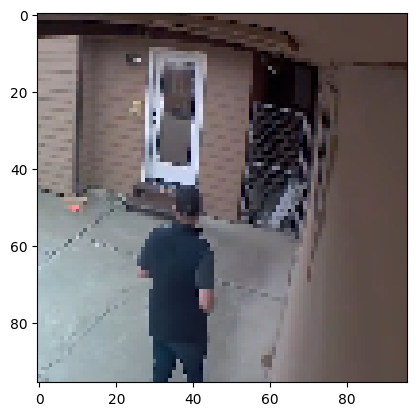

In [25]:
img = keras.utils.load_img("/home/pico/code/human_presence_classifier/data/human_dataset/test/human/78.png", target_size=(96, 96))
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
# Reescale image values from 0-255 to 0-1
rescale_fn = layers.Rescaling(1.0 / 255)
img_array = rescale_fn(img_array)
# Add batch dimension
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(f"This image is {100 * (1 - predictions[0][0]):.2f}% human and {100 * predictions[0][0]:.2f}% not human.")
print(predictions)

<tf.Tensor: shape=(1, 3, 96, 96), dtype=float32, numpy=
array([[[[0.10980393, 0.20392159, 0.25490198, ..., 0.1137255 ,
          0.09019608, 0.34117648],
         [0.18039216, 0.20784315, 0.1137255 , ..., 0.5294118 ,
          0.62352943, 0.38823533],
         [0.3254902 , 0.2784314 , 0.17254902, ..., 0.3254902 ,
          0.43921572, 0.28627452],
         ...,
         [0.6431373 , 0.70980394, 0.72156864, ..., 0.6509804 ,
          0.6509804 , 0.6431373 ],
         [0.68235296, 0.69411767, 0.6784314 , ..., 0.6117647 ,
          0.60784316, 0.58431375],
         [0.67058825, 0.68235296, 0.6862745 , ..., 0.63529414,
          0.63529414, 0.63529414]],

        [[0.15294118, 0.2392157 , 0.28627452, ..., 0.1254902 ,
          0.10588236, 0.36078432],
         [0.20000002, 0.23137257, 0.14509805, ..., 0.54509807,
          0.6431373 , 0.40784317],
         [0.34901962, 0.3019608 , 0.20000002, ..., 0.34509805,
          0.45882356, 0.30588236],
         ...,
         [0.56078434, 0.6117647 